**Distratced Driving Detection using Keras in R**

In [5]:
#Load the libraries
library(tidyverse)
library(keras)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.0.9000     ✔ purrr   0.3.3     
✔ tibble  2.1.3          ✔ dplyr   0.8.4     
✔ tidyr   1.0.2          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



**List Files**

In [6]:
list.files("../input/state-farm-distracted-driver-detection")

list.files('../input/state-farm-distracted-driver-detection/imgs/train')

head(list.files('../input/state-farm-distracted-driver-detection/imgs/test'))

head(read.csv('../input/state-farm-distracted-driver-detection/sample_submission.csv'))

head(read.csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv'))

[1] "driver_imgs_list.csv"  "imgs"                  "sample_submission.csv"

[1] "c0" "c1" "c2" "c3" "c4" "c5" "c6" "c7" "c8" "c9"

[1] "img_1.jpg"      "img_10.jpg"     "img_100.jpg"    "img_1000.jpg"  
[5] "img_100000.jpg" "img_100001.jpg"

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
5,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
6,img_100001.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


,subject,classname,img
,<fct>,<fct>,<fct>
1,p002,c0,img_44733.jpg
2,p002,c0,img_72999.jpg
3,p002,c0,img_25094.jpg
4,p002,c0,img_69092.jpg
5,p002,c0,img_92629.jpg
6,p002,c0,img_3370.jpg


**Build Generators**

In [7]:
train_dir <- '../input/state-farm-distracted-driver-detection/imgs/train'
test_dir <- '../input/state-farm-distracted-driver-detection/imgs/test'

train_datagen = image_data_generator(rescale = 1/255, data_format='channels_last', validation_split=.5)
test_datagen <- image_data_generator(rescale = 1/255, data_format='channels_last')  

train_generator <- flow_images_from_directory(
  train_dir,                  # Target directory  
  train_datagen,              # Data generator
  target_size = c(256, 256),  # Resizes all images
  batch_size = 4,
  class_mode = "categorical",       
  subset='training'
)

validation_generator <- flow_images_from_directory(
  train_dir,                  # Target directory  
  train_datagen,              # Data generator
  target_size = c(256, 256),  # Resizes all images
  batch_size = 4,
  class_mode = "categorical",       
  subset='validation'
)

test_generator <- flow_images_from_directory(
  test_dir,                  # Target directory  
  test_datagen,              # Data generator
  target_size = c(256, 256),  # Resizes all images
  batch_size = 4,
  shuffle=FALSE,
  class_mode = NULL
)

** Build Model**

In [8]:
model <- keras_model_sequential()

model %>%
  
  # Start with hidden 2D convolutional layer being fed 32x32 pixel images
  layer_conv_2d(
    filter = 16, kernel_size = c(2), padding = "same", 
    input_shape = c(256, 256, 3),
      activation='relu') %>%
  layer_batch_normalization() %>%
  # Second hidden layer
  layer_conv_2d(filter = 128, kernel_size = c(2), activation='relu') %>%
  layer_batch_normalization() %>%    

  # Use max pooling
  layer_max_pooling_2d(pool_size = c(2)) %>%
  layer_dropout(rate=.2) %>%
      
  # 1 additional hidden 2D convolutional layers
  layer_conv_2d(filter = 64, kernel_size = c(4), padding = "same", activation='relu') %>%
  layer_batch_normalization() %>%
  layer_conv_2d(filter = 64, kernel_size = c(4), activation='relu') %>%
  layer_batch_normalization() %>%

  layer_max_pooling_2d(pool_size = c(2)) %>%
  layer_dropout(rate=.2) %>%

  # Flatten max filtered output into feature vector 
  # and feed into dense layer
  layer_flatten() %>%
  layer_dropout(rate=.2) %>%

  #layer_dense(128, activaton='relu') %>% 
  
  # Outputs from dense layer are projected onto 10 unit output layer
  layer_dense(10, activation='softmax')

In [9]:
str(model)

Model
Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 256, 256, 16)            208         
________________________________________________________________________________
batch_normalization (BatchNormaliza (None, 256, 256, 16)            64          
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 255, 255, 128)           8320        
________________________________________________________________________________
batch_normalization_1 (BatchNormali (None, 255, 255, 128)           512         
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 127, 127, 128)           0           
________________________________________________________________________________
dr

**Compile Model**

In [10]:
opt <- optimizer_rmsprop(lr = 0.001, decay = 1e-6)

model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = opt,
  metrics = "accuracy"
)

**Fit Model**

`geom_smooth()` using formula 'y ~ x'



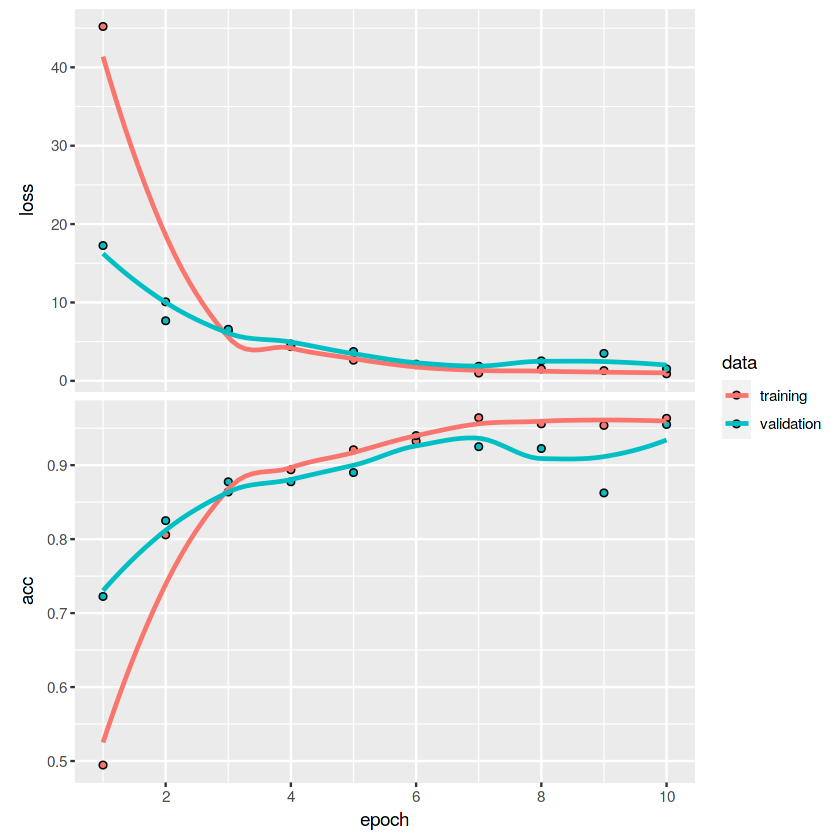

In [11]:
history <- model %>% fit_generator(
  train_generator,
  steps_per_epoch = 600,
  epochs = 10,
  validation_data=validation_generator,
  validation_steps=100
)

plot(history)

**** Evaluate Model ****

In [ ]:
model %>% evaluate_generator(train_generator, steps=50)

In [15]:
model %>% evaluate_generator(validation_generator, steps=50)

$loss
[1] 0.6206855

$acc
[1] 0.985

**Test Ramdom Example**

[1] "operating the radio"

V1,class
<dbl>,<chr>
0,Safe Driving
0,texting - right
0,talking on the phone - right
0,texting - left
0,talking on the phone - left
1,operating the radio
0,drinking
0,reaching behind
0,hair and makeup


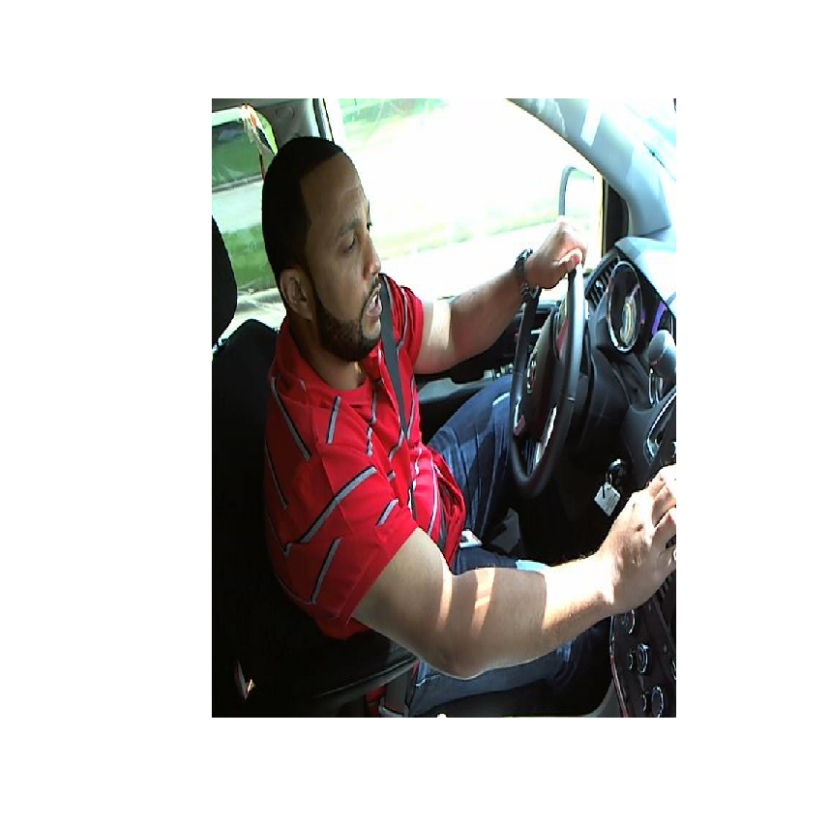

In [40]:
classes <- c('Safe Driving', 'texting - right', 'talking on the phone - right', 'texting - left',
             'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
             'hair and makeup', 'talking to passenger')

file <- sample(list.files(test_dir),1)

img_path <- paste(test_dir, file, sep='/')         
img <- image_load(img_path, target_size = c(256, 256)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 256, 256, 3)) 


p_class <- predict_classes(model, img)
preds <- as.data.frame(t(predict_proba(model, img)))
preds$class <- classes


classes[p_class+1]
preds


img_ <- image_load(img_path, target_size = c(640, 480)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 640, 480, 3)) 


img_tensor=img_/255
plot(as.raster(img_tensor[1,,,]))

[1] "texting - right"

V1,class
<dbl>,<chr>
0,normal driving
1,texting - right
0,talking on the phone - right
0,texting - left
0,talking on the phone - left
0,operating the radio
0,drinking
0,reaching behind
0,hair and makeup


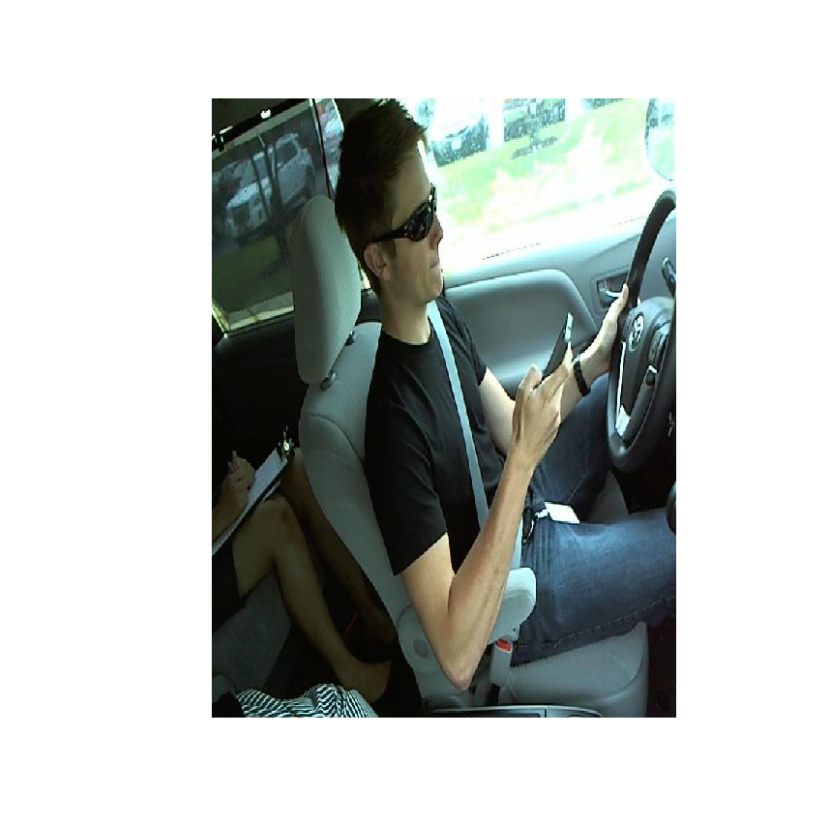

In [25]:
#classes <- c('Safe Driving', 'texting - right', 'talking on the phone - right', 'texting - left',
#             'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
#             'hair and makeup', 'talking to passenger')

file <- sample(list.files(test_dir),1)

img_path <- paste(test_dir, file, sep='/')         
img <- image_load(img_path, target_size = c(256, 256)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 256, 256, 3)) 


p_class <- predict_classes(model, img)
preds <- as.data.frame(t(predict_proba(model, img)))
preds$class <- classes


classes[p_class+1]
preds


img_ <- image_load(img_path, target_size = c(640, 480)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 640, 480, 3)) 


img_tensor=img_/255
plot(as.raster(img_tensor[1,,,]))

[1] "hair and makeup"

V1,class
<dbl>,<chr>
0,normal driving
0,texting - right
0,talking on the phone - right
0,texting - left
0,talking on the phone - left
0,operating the radio
0,drinking
0,reaching behind
1,hair and makeup


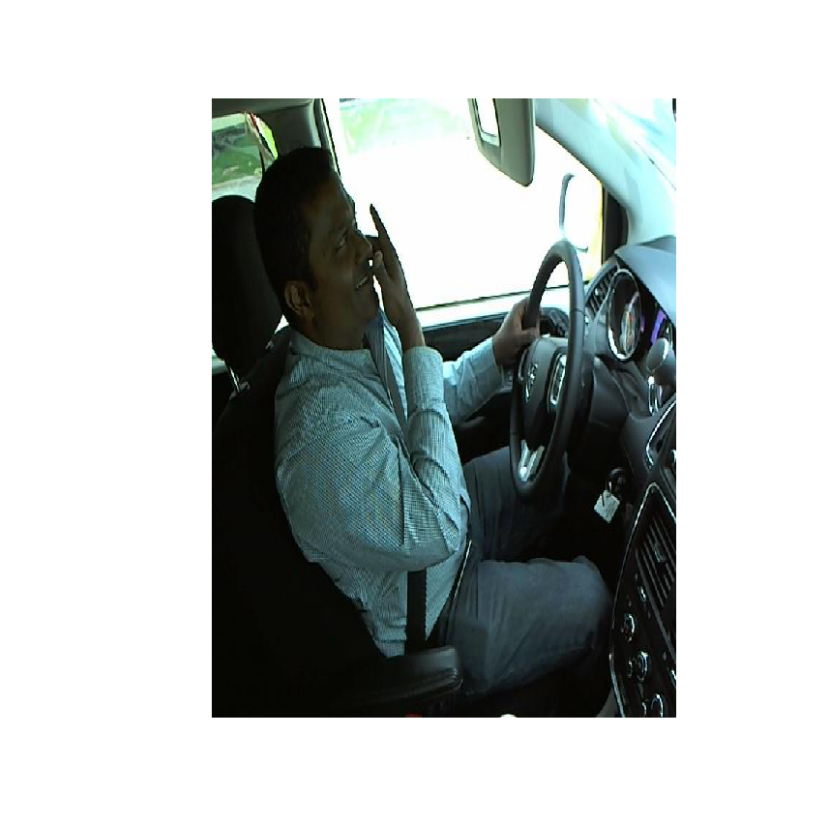

In [27]:
#classes <- c('Safe Driving', 'texting - right', 'talking on the phone - right', 'texting - left',
#             'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
#             'hair and makeup', 'talking to passenger')

file <- sample(list.files(test_dir),1)

img_path <- paste(test_dir, file, sep='/')         
img <- image_load(img_path, target_size = c(256, 256)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 256, 256, 3)) 


p_class <- predict_classes(model, img)
preds <- as.data.frame(t(predict_proba(model, img)))
preds$class <- classes


classes[p_class+1]
preds


img_ <- image_load(img_path, target_size = c(640, 480)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 640, 480, 3)) 


img_tensor=img_/255
plot(as.raster(img_tensor[1,,,]))

[1] "talking on the phone - left"

V1,class
<dbl>,<chr>
0,normal driving
0,texting - right
0,talking on the phone - right
0,texting - left
1,talking on the phone - left
0,operating the radio
0,drinking
0,reaching behind
0,hair and makeup


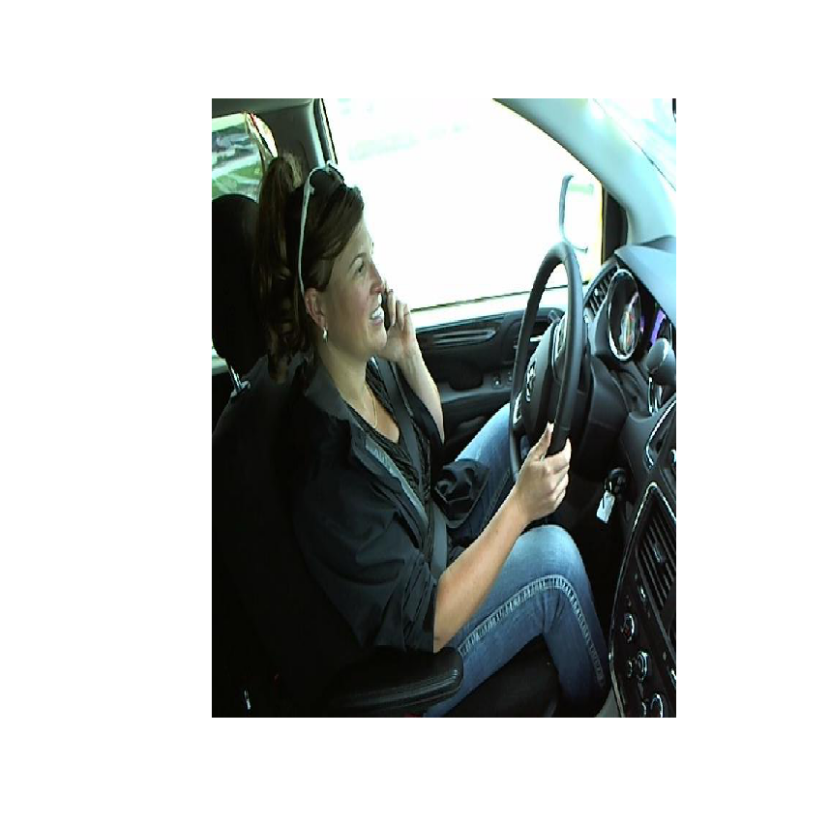

In [20]:
#classes <- c('Safe Driving', 'texting - right', 'talking on the phone - right', 'texting - left',
#             'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
#             'hair and makeup', 'talking to passenger')

file <- sample(list.files(test_dir),1)

img_path <- paste(test_dir, file, sep='/')         
img <- image_load(img_path, target_size = c(256, 256)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 256, 256, 3)) 


p_class <- predict_classes(model, img)
preds <- as.data.frame(t(predict_proba(model, img)))
preds$class <- classes


classes[p_class+1]
preds


img_ <- image_load(img_path, target_size = c(640, 480)) %>%           
  image_to_array() %>%                                               
  array_reshape(dim = c(1, 640, 480, 3)) 


img_tensor=img_/255
plot(as.raster(img_tensor[1,,,]))

**Save Model**

In [41]:
save_model_hdf5(model, 'model_v5.h5', overwrite = TRUE,
  include_optimizer = TRUE)